In [1]:
from van_der_waals import *
import time
import scipy.optimize as op
from tqdm import tqdm

In [2]:
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
#     'font.size' : 14.4,
    'font.size' : 17.28,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# Models

<IPython.core.display.Javascript object>


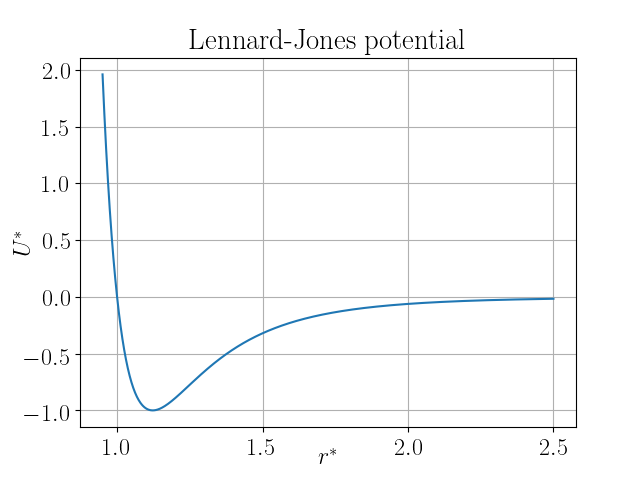

In [8]:
%matplotlib notebook

@np.vectorize
def lj(r):
    return 4*(r**(-12) - r**(-6))

rs = np.linspace(0.95,2.5,1000)

fig,ax = plt.subplots()
ax.xaxis.set_label_coords(0.5,-0.05)
ax.yaxis.set_label_coords(-0.09,0.5)
ax.plot(rs,lj(rs))
ax.grid()
ax.set_xlabel('$r^*$')
ax.set_ylabel('$U^*$')
ax.set_title('Lennard-Jones potential')
# fig.savefig('report/img/lj.pgf')

In [3]:
@np.vectorize
def vdw(v,T,a,b):
    return T/(v - b) - a/v**2

a = 3.81
b = 0.886
Tc = 8*a/(27*b)
Pc = a/(27*b**2)
vc = 3*b

v_min = 1.3*b + 0.01
v_step = 0.001
vs_fine = np.arange(v_min,15,v_step)
def v_index(v):
    return int((v - vmin)/v_step)

def find_ig(i_l,ps,i_min):
    p_e = ps[i_l]
    if i_l > i_min:
        return 0
    if p_e > np.max(ps[i_min:]):
        return 0
    delta_p = -1
    trigger = False
    for i_g,p_g in enumerate(ps[i_min:]):
        delta_p = p_g - p_e
        #print(delta_p)
        if delta_p > 0 and not trigger:
            trigger = True
        if delta_p < 0 and trigger:
            return i_g + i_min
    return 0
        
    
def coexistence_limits(ps):
    i_min = 0
    for i,p in enumerate(ps):
        if i == 0:
            continue
        if p - ps[i-1] > 0:
            i_min = i
            break
    indexs = []
    for i_l in range(i_min):
        i_g = find_ig(i_l,ps,i_min)
        if i_g == 0:
            indexs.append([i_l,i_g,1000])
        else:
            s = np.sum(ps[i_l:i_g] - ps[i_l])
            indexs.append([i_l,i_g,s])
#             print(s)
    
    indexs = np.array(indexs)
    j = np.argmin(np.abs(indexs[:,2]))
    return vs_fine[int(indexs[j,0])], vs_fine[int(indexs[j,1])], ps[int(indexs[j,0])]
        
    

2.980999999999816 3.018999999999812 0.9999600059853644


<IPython.core.display.Javascript object>


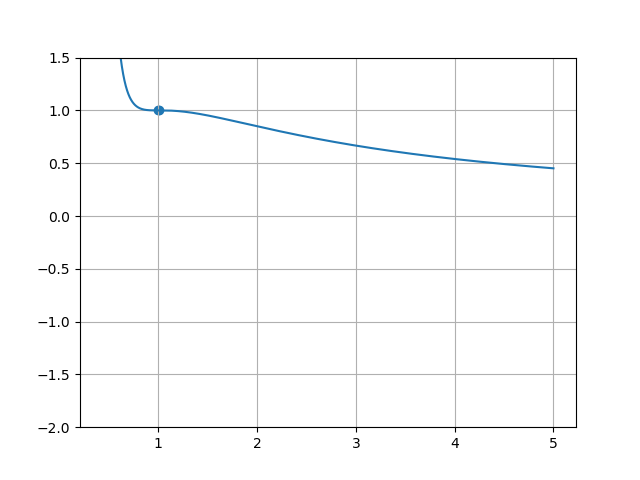

In [44]:
%matplotlib notebook
T = 0.99*Tc
ps = vdw(vs_fine,T,a,b)/Pc
vl,vg,pe = coexistence_limits(ps)
print(vl,vg,pe)

plt.figure()
plt.ylim(-2,1.5)
plt.grid()
plt.plot(vs_fine/vc,ps)

plt.scatter([vl/vc,vg/vc],[pe,pe])

In [12]:
T_fine = np.linspace(0.75,0.9999,100)*Tc
vs1 = []
vs2 = []
ps1 = []
ps2 = []
for T in tqdm(T_fine):
    ps = vdw(vs_fine,T,a,b)/Pc
    vl,vg,pe = coexistence_limits(ps)
    vs1.append(vl/vc)
    vs2.append(vg/vc)
    ps1.append(pe)
    ps2.append(pe)

vs2.reverse()
ps2.reverse()
vss = np.array(vs1 + vs2)
pss = np.array(ps1 + ps2)

100%|██████████| 100/100 [02:19<00:00,  1.40s/it]


<IPython.core.display.Javascript object>


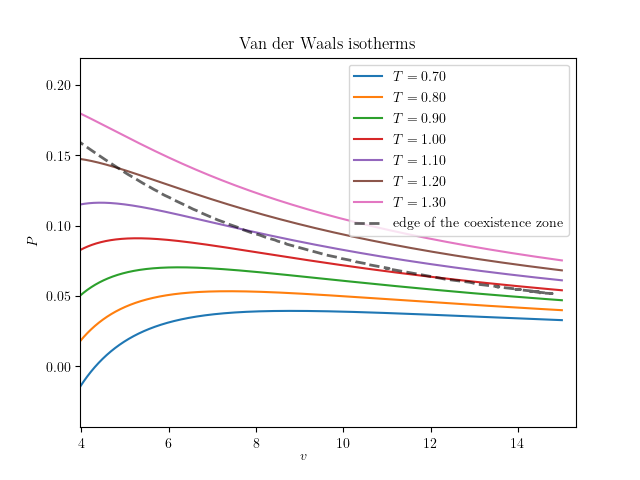

In [14]:
%matplotlib notebook
ts = np.array([0.7,0.8,0.9,1.,1.1,1.2, 1.3])
fig,ax = plt.subplots()
ax.set_ylim(-0.7,0.5)
ax.xaxis.set_label_coords(0.45,-0.06)
for t in ts:
    ps = vdw(vs_fine,t,a,b)
    ax.plot(vs_fine,ps,label='$T = %.2f $' %t)
ax.plot(vss*vc,pss*Pc,color='black',linestyle='dashed',linewidth=2,alpha=0.6,label='edge of the coexistence zone')
ax.set_xlabel('$v$')
ax.set_ylabel('$P$')
ax.set_title('Van der Waals isotherms')
ax.legend()
# fig.savefig('report/img/vdw_isotherms.pgf')

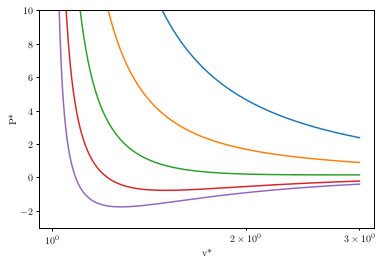

In [23]:


Ts = np.array([4,2,1,0.5,0.25])*Tc
vs = np.linspace(1.01,3,1000)

plt.figure()
plt.xlabel('v*')
plt.ylabel('P*')
plt.ylim(-3,10)
for T in Ts:
    plt.semilogx(vs,vdw(vs,T,a,b))
    

# Simulations

In [3]:
def index_keys(keys,iks=['T_imp','v_imp','N_avg_points','time']):
    for k in keys:
        iks.append(k)
        iks.append(k+'_std')
    return np.array(iks)

In [4]:
big_folder = 'NVT/testing'
T = 1.7
l = 1.8
N_atoms = 11
run = int(2e5)
average_keys = ['Temp','Press']
thermo_keys = ['step', 'temp', 'press', 'etotal', 'pe']
dt = 0.004
r_c = 2.5

v = l**3
print('simulating @ T = %.2f, v = %.2f' %(T,v))
sub_folder = big_folder+('/T_%.2f__v_%.2f' %(T,v))
make_input_data(sub_folder,Nx=N_atoms,L=l)

# start_time = time.time()
# lmp_data = simulate(folder=sub_folder,input_data_file=sub_folder+'/lattice.data',mode='nvt',
#                 thermo_keys=thermo_keys, dist='gaussian',
#                 use_correlation = False, minstep=20000, block_average_size=100,
#                 T=T,T0=T,tau_T=200*dt,verbose=True,run=run,thermo_rate=100, analyze=False,
#                 average_keys=average_keys,r_c=r_c)
# end_time = time.time()
# print(int(end_time - start_time))

simulating @ T = 1.70, v = 5.83


## Testing r_c

In [5]:
big_folder = 'NVT/testing_rc'
ofile = 'results.csv'

average_keys = ['Temp','Press']
thermo_keys = ['step', 'temp', 'press', 'etotal', 'pe']
dt = 0.004

Ts = [1.7]
ls = [1.3,1.8]

r_cs = [2.,2.5,3.,3.5]
shifts = [True,False]



In [ ]:
#simulate

if not os.path.exists(big_folder):
    os.mkdir(big_folder)
if not os.path.exists(big_folder+'/'+ofile):
    df = pd.DataFrame(data=[],columns=index_keys(average_keys,
                                                 iks=['T_imp','v_imp','N_avg_points','time','r_c','shift']))
else:
    df = pd.read_csv(big_folder+'/'+ofile)

print('Launching %d simulations' %(len(Ts)*len(ls)*len(r_cs)*len(shifts)))
for T in Ts:
    for l in ls:
        v = l**3
        for r_c in r_cs:
            for shift in shifts:
                sub_folder = big_folder+('/T_%.2f__v_%.2f__rc_%.2f' %(T,v,r_c))
                if shift:
                    sub_folder += '__shifted'
                print('simulating in '+sub_folder)
                
                make_input_data(sub_folder,Nx=11,L=l)
                
                avgs,n_good_data,t = simulate(folder=sub_folder,input_data_file=sub_folder+'/lattice.data',
                                                 mode='nvt',thermo_keys=thermo_keys,dist='gaussian',timestep=dt,
                                                 use_correlation=False,minstep=20000,block_average_size=100,
                                                 T=T,T0=T,tau_T=200*dt,verbose=True,run=200000,thermo_rate=100,
                                                 average_keys=average_keys,r_c=r_c,shift=shift)
                
                df.loc[len(df)] = [T,v,n_good_data,t,r_c,shift] + list(avgs)
df.to_csv(big_folder+'/'+ofile,index=False)
        

In [6]:
# load

df = pd.read_csv(big_folder+'/'+ofile)

<IPython.core.display.Javascript object>


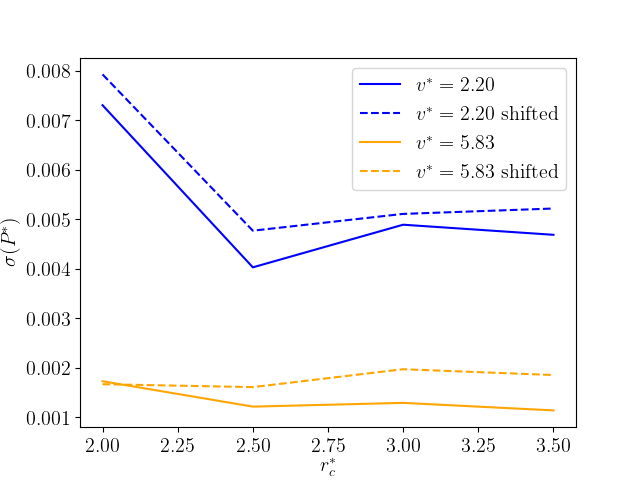

In [26]:
%matplotlib notebook
key = 'Press_std'
colors = ['blue','orange','red','green']
plt.figure()
i = -1
for l in ls[:]:
    i += 1
    for shift in [False,True]:
        xs = np.array([r for i,r in enumerate(df['r_c']) if df['shift'][i] == shift and np.abs(df['v_imp'][i] - l**3) < 1])
        ys = np.array([k for i,k in enumerate(df[key]) if df['shift'][i] == shift and np.abs(df['v_imp'][i] - l**3) < 1])
        label = '$v^* = %.2f$' % l**3
        if shift:
            label += ' shifted'
            plt.plot(xs,ys,label=label,linestyle='dashed',color=colors[i])
        else:
            plt.plot(xs,ys,label=label,color=colors[i])
plt.legend()
plt.xlabel('$r_c^*$')
plt.ylabel('$\sigma(P^*)$')

plt.savefig('report/img/sigPvsr_c.pgf')

<IPython.core.display.Javascript object>


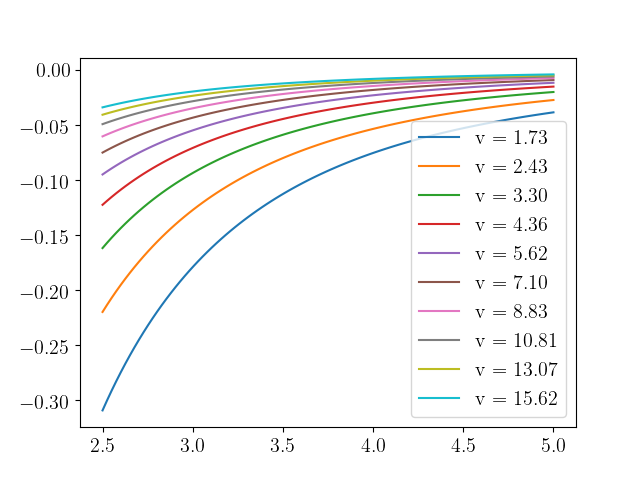

In [10]:
#tail correction
@np.vectorize
def U_tail_corr(r_c,v):
    return 8*np.pi/v*(r_c**(-9)/9 - r_c**(-3)/3)

@np.vectorize
def P_tail_corr(r_c,v):
    return 16*np.pi/v**2*(2*r_c**(-9)/9 - r_c**(-3)/3)

r_cs = np.linspace(2.5,5,100)
vs = np.linspace(1.2,2.5,10)**3

plt.figure()
for v in vs:
    plt.plot(r_cs,U_tail_corr(r_cs,v),label='v = %.2f'%v)
plt.legend()

<IPython.core.display.Javascript object>


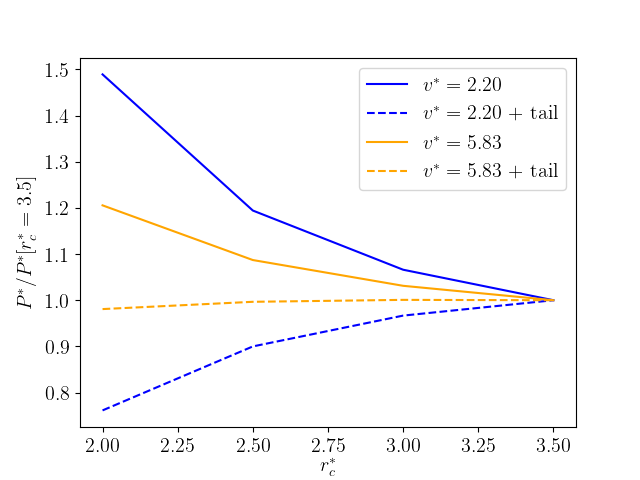

In [32]:
%matplotlib notebook
key = 'Press'
tails = [False,True]
plt.figure()
colors = ['blue','orange','red','green']
i = -1
for l in ls[:]:
    v = l**3
    for shift in shifts[1:]:
        i += 1
        for tail in tails:
            xs = np.array([r for i,r in enumerate(df['r_c']) if df['shift'][i] == shift and np.abs(df['v_imp'][i] - v) < 1])
            ys = np.array([k for i,k in enumerate(df[key]) if df['shift'][i] == shift and np.abs(df['v_imp'][i] - v) < 1])
            label = '$v^* = %.2f$' % v
            if tail:
                ys += P_tail_corr(xs,v)
                label += ' + tail'
            if shift:
                label += ' shifted'
            if tail:
                plt.plot(xs,ys/ys[-1],label=label,linestyle='dashed',color=colors[i])
            else:
                plt.plot(xs,ys/ys[-1],label=label,color=colors[i])
plt.legend()
plt.xlabel('$r_c^*$')
plt.ylabel('$P^*/P^*[r_c^* = 3.5]$')

plt.savefig('report/img/Pvsr_c.pgf')

## Testing neighbor list

In [23]:
big_folder = 'NVT/testing_neigh'
ofile = 'results.csv'

average_keys = ['Temp','Press']
thermo_keys = ['step', 'temp', 'press', 'etotal', 'pe']
dt = 0.004

Ts = [1.7]
ls = [1.3,1.8]

skins = [0.2,0.3,0.4]
everys = [1]
delays = [10,20]
checks = [False,True]

In [19]:
if not os.path.exists(big_folder):
    os.mkdir(big_folder)
if not os.path.exists(big_folder+'/'+ofile):
    df = pd.DataFrame(data=[],columns=index_keys(average_keys,
                                                 iks=['T_imp','v_imp','N_avg_points','time',
                                                      'skin','every','delay','check']))
else:
    df = pd.read_csv(big_folder+'/'+ofile)

print('Launching %d simulations' %(len(Ts)*len(ls)*len(skins)*len(everys)*len(delays)*len(checks)))
for T in Ts:
    for l in ls:
        v = l**3
        for skin in skins:
            for every in everys:
                for delay in delays:
                    for check in checks:
                        sub_folder = big_folder+('/T_%.2f__v_%.2f__skin_%.2f' %(T,v,skin))
                        if every > 1:
                            sub_folder += '__every_%d' %every
                        else:
                            sub_folder += '__delay_%d' %delay
                        if check:
                            sub_folder += '__checked'
                        print('simulating in '+sub_folder)

                        make_input_data(sub_folder,Nx=11,L=l)

                        avgs,n_good_data,t = simulate(folder=sub_folder,input_data_file=sub_folder+'/lattice.data',
                                                      mode='nvt',thermo_keys=thermo_keys,dist='gaussian',
                                                      timestep=dt,use_correlation=False,minstep=20000,
                                                      block_average_size=100,T=T,T0=T,tau_T=200*dt,verbose=True,
                                                      run=200000,thermo_rate=100,average_keys=average_keys,
                                                      r_c=3.0,shift=True,skin_depth=skin,neigh_update_rate=every,
                                                      delay=delay,check=check)
                
                        df.loc[len(df)] = [T,v,n_good_data,t,skin,every,delay,check] + list(avgs)
df.to_csv(big_folder+'/'+ofile,index=False)

Launching 24 simulations
simulating in NVT/testing_neigh/T_1.70__v_2.20__skin_0.20__delay_10
written file NVT/testing_neigh/T_1.70__v_2.20__skin_0.20__delay_10/in.inp
data production starts from step 24950
153.2315866947174
simulating in NVT/testing_neigh/T_1.70__v_2.20__skin_0.20__delay_10__checked
written file NVT/testing_neigh/T_1.70__v_2.20__skin_0.20__delay_10__checked/in.inp
data production starts from step 24950
154.36989641189575
simulating in NVT/testing_neigh/T_1.70__v_2.20__skin_0.20__delay_20
written file NVT/testing_neigh/T_1.70__v_2.20__skin_0.20__delay_20/in.inp
data production starts from step 24950
133.7494819164276
simulating in NVT/testing_neigh/T_1.70__v_2.20__skin_0.20__delay_20__checked
written file NVT/testing_neigh/T_1.70__v_2.20__skin_0.20__delay_20__checked/in.inp
data production starts from step 24950
134.59706163406372
simulating in NVT/testing_neigh/T_1.70__v_2.20__skin_0.30__delay_10
written file NVT/testing_neigh/T_1.70__v_2.20__skin_0.30__delay_10/in.inp

In [21]:
#only analyze
df = pd.read_csv(big_folder+'/'+ofile)

for T in Ts:
    for l in ls:
        v = l**3
        for skin in skins:
            for every in everys:
                for delay in delays:
                    for check in checks:
                        sub_folder = big_folder+('/T_%.2f__v_%.2f__skin_%.2f' %(T,v,skin))
                        if every > 1:
                            sub_folder += '__every_%d' %every
                        else:
                            sub_folder += '__delay_%d' %delay
                        if check:
                            sub_folder += '__checked'                        

                        avgs = []
                        lmp_data = pd.read_csv(sub_folder+'/results.log',sep=' ',header = 14,
                                               usecols=np.arange(len(thermo_keys)),
                                               nrows=(2001),skipinitialspace=True)
                        lmp_data = block_average(lmp_data,100)
                        min_index = 2
                        for key in average_keys:
                            avgs.append(np.mean(lmp_data[key][min_index:]))
                            avgs.append(np.std(lmp_data[key][min_index:],ddof=1))
                
                        df.loc[len(df)] = [T,v,18,0,skin,every,delay,check] + list(avgs)
df.to_csv(big_folder+'/'+ofile,index=False)

In [23]:
df.to_csv(big_folder+'/'+ofile,index=False)

In [20]:
# load
df = pd.read_csv('NVT/testing_neigh/results.csv')

In [18]:
df.keys()

Index(['T_imp', 'v_imp', 'N_avg_points', 'time', 'skin', 'every', 'delay',
       'check', 'Temp', 'Temp_std', 'Press', 'Press_std'],
      dtype='object')

In [21]:
def i_list(data,T='free',v='free',skin='free',every='free',delay='free',check='free'):
    i_l = []
    for i in range(len(data)):
        if T != 'free':
            if np.abs(data['T_imp'][i] - T) > 0.05:
                continue
        if v != 'free':
            if np.abs(data['v_imp'][i] - v) > 0.1:
                continue
        if skin != 'free':
            if np.abs(data['skin'][i] - skin) > 0.05:
                continue
        if every != 'free':
            if data['every'][i] != every:
                continue
        if delay != 'free':
            if data['delay'][i] != delay:
                continue
        if check != 'free':
            if data['check'][i] != check:
                continue
        i_l.append(i)
    return i_l
        

<IPython.core.display.Javascript object>


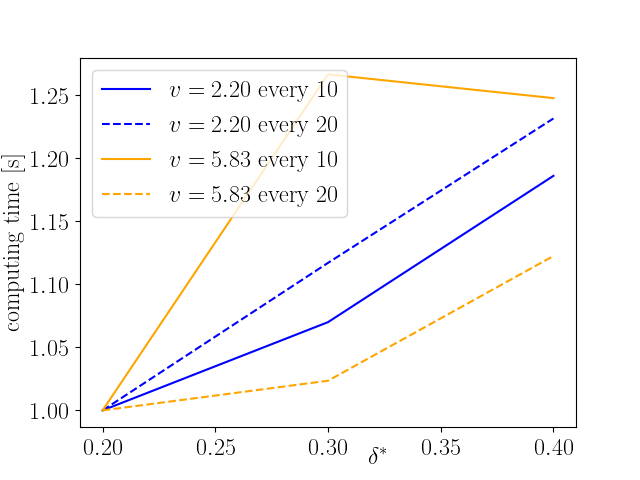

In [26]:
%matplotlib notebook
T = 1.7
vs = (np.array(ls)**3)[:]
everys = [1,10,20][1:]
delays = [0,10,20][:1]
checks = [False]

colors = ['blue','orange','red','green']
i = -1
linestyles = ['solid','dashed','dotted']

# key = 'Press_std'
key = 'time'

fig, ax = plt.subplots()
ax.xaxis.set_label_coords(0.6,-0.05)
for v in vs:
    i += 1
#     for skin in skins:
    j = -1
    for every in everys:
        j += 1
        for delay in delays:
            for check in checks:
                label = '$v = %.2f$' %v
                if every > 1:
                    label += ' every %d' %every
                if delay > 0:
                    label += ' delay %d' %delay
                if check:
                    label += ' checked'
            
                i_l = i_list(df,T=T,v=v,skin='free',every=every,delay=delay,check=check)
                if len(i_l) == 0:
                    continue
                ax.plot(skins,df[key][i_l]/df[key][i_l[0]],label=label,color=colors[i],linestyle=linestyles[j])
#                 plt.plot(skins,df[key][i_l],label=label,color=colors[i],linestyle=linestyles[j])
plt.legend()
ax.set_xlabel('$\delta^*$')
# ax.set_ylabel('$\sigma(P^*)/\sigma(P^*)[\delta^* = 0.2]$')
ax.set_ylabel('computing time [s]')

# plt.savefig('report/img/computing_time.pgf')
# plt.savefig('report/img/sigPvsdelta.pgf')

## Analysis of the single simulation

In [5]:
lmp_data = pd.read_csv('NVT/testing/T_1.70__v_5.83/results.log',sep=' ',header = 14,usecols=np.arange(4),
                   nrows=(10001),skipinitialspace=True)

In [63]:
lmp_data.values[0]

array([ 0.       ,  1.7      ,  0.1766798,  2.2689455, -0.2791386])

In [4]:
def correlation(data,start,end,key):
    mx = np.mean(data['Step'][start:end])
    my = np.mean(data[key][start:end])
    Exy = np.mean(data['Step'][start:end]*data[key][start:end]) - mx*my
    return Exy/(np.std(data['Step'][start:end])*np.std(data[key][start:end]))

In [5]:
@np.vectorize
def linfunc(x,m,q):
    return m*x + q

def linfit(data,minstep,key,maxstep=0,plot=False):
    if maxstep == 0:
        xs = np.array([s for s in data['Step'] if s > minstep])
        ys = np.array([k for i,k in enumerate(data[key]) if data['Step'][i] > minstep])
    else:
        xs = np.array([s for s in data['Step'] if s > minstep and s < maxstep])
        ys = np.array([k for i,k in enumerate(data[key]) if data['Step'][i] > minstep and data['Step'][i] < maxstep])
    popt,pcov = op.curve_fit(linfunc, xs, ys, p0=[1.,1.])
    if plot:
        plt.figure()
        plt.plot(xs,ys)
        plt.plot(xs,linfunc(xs,*popt))
        plt.show()
    return popt,pcov

<IPython.core.display.Javascript object>


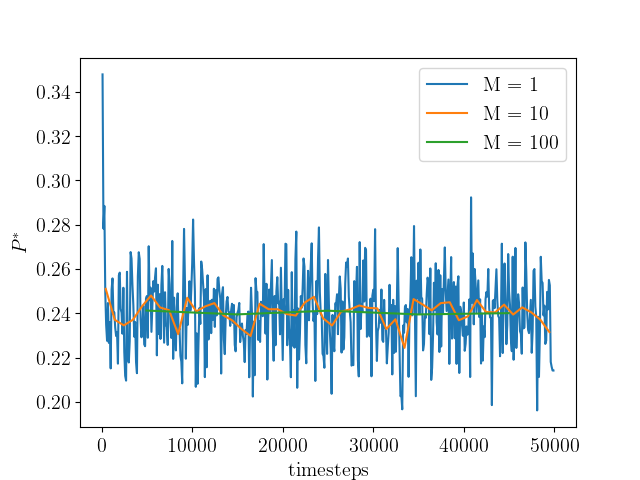

[-4.28335750e-08  2.41474946e-01] [[ 2.84637351e-15 -7.11593379e-11]
 [-7.11593379e-11  2.36960596e-06]]
[-2.50009337e-08  2.40900431e-01] [[ 2.61269201e-15 -6.51866637e-11]
 [-6.51866637e-11  2.17050030e-06]]
[-2.38180760e-08  2.40870919e-01] [[ 8.13248135e-16 -2.02905626e-11]
 [-2.02905626e-11  6.68899625e-07]]


In [44]:
%matplotlib notebook
key = 'Press'
minstep = 0
maxstep = 50000
coarse_sampling = 1
ns = [1,10,100]
plt.figure()
for n in ns:
    data = block_average(lmp_data,n,coarse_sampling)
    xs = np.array([s for s in data['Step'] if s > minstep and s < maxstep])
    ys = np.array([k for i,k in enumerate(data[key]) if data['Step'][i] > minstep and data['Step'][i] < maxstep])
    plt.plot(xs,ys,label='M = %d' %n)
    popt,pcov = linfit(data,minstep,key,maxstep=maxstep,plot=False)
    print(popt,pcov)
    
plt.xlabel('timesteps')
plt.ylabel('$P^*$')
plt.legend()
plt.savefig('report/img/equilibration2.pgf')


 60%|██████    | 9/15 [00:20<00:06,  1.03s/it]

<IPython.core.display.Javascript object>


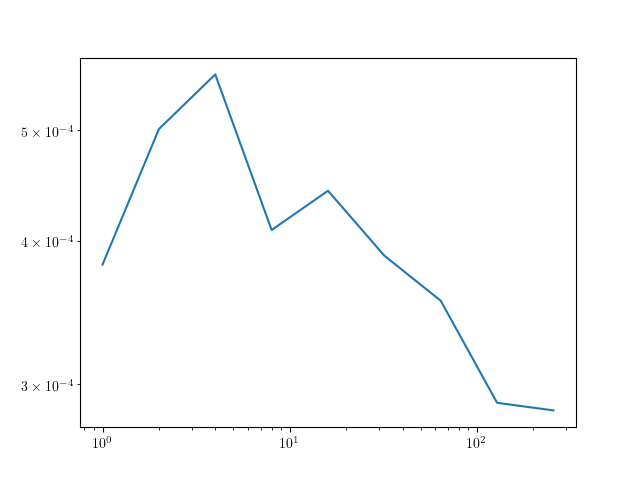

array([9970, 4985, 2492, 1246,  623,  311,  156,   78,   39])

In [16]:
minstep = 3000
maxstep = 100000
coarse_sampling = 1
coarsed_data = block_average(lmp_data,1,coarse_sampling)
ns = 2**np.arange(15)
key = 'Temp'
sigs = []
n_data = []
for n in tqdm(ns):
    data = block_average(coarsed_data,n)
    min_index = 0
    for i,s in enumerate(data['Step']):
        if s > minstep:
            min_index = i
            #print(min_index)
            break
    max_index = len(data['Step'])
    for i in reversed(range(len(data['Step']))):
        if data['Step'][i] < maxstep:
            max_index = i
            #print(min_index)
            break
    if(len(data['Step'][min_index:max_index]) <= 1):
        break
    n_data.append(len(data['Step'][min_index:]))
    sigs.append(np.std(data[key][min_index:],ddof=1)/np.sqrt(len(data['Step'][min_index:])))
n_data = np.array(n_data)
sigs = np.array(sigs)

plt.figure()
plt.plot(ns[:len(sigs)],sigs/sigs[0])
# plt.plot(ns,n_data/n_data[0])
n_data

<IPython.core.display.Javascript object>


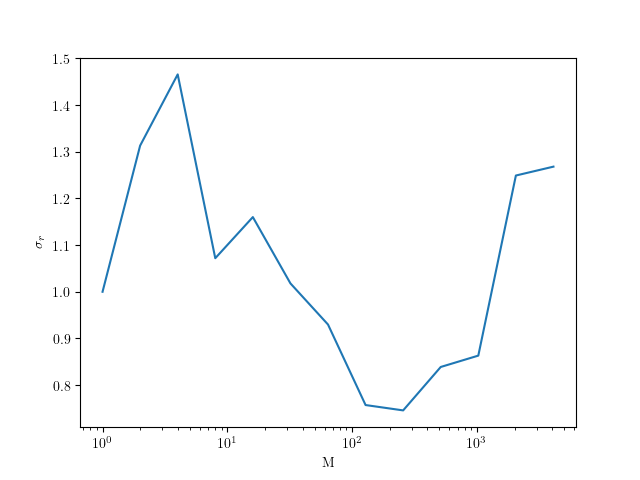

In [13]:
%matplotlib notebook
plt.figure()
plt.semilogx(ns[:len(sigs)],sigs/sigs[0])
# plt.plot(ns,n_data/n_data[0])
plt.xlabel('M')
plt.ylabel('$\sigma_r$')
#plt.savefig('report/img/block_averages_M.pgf')
plt.show()

<IPython.core.display.Javascript object>


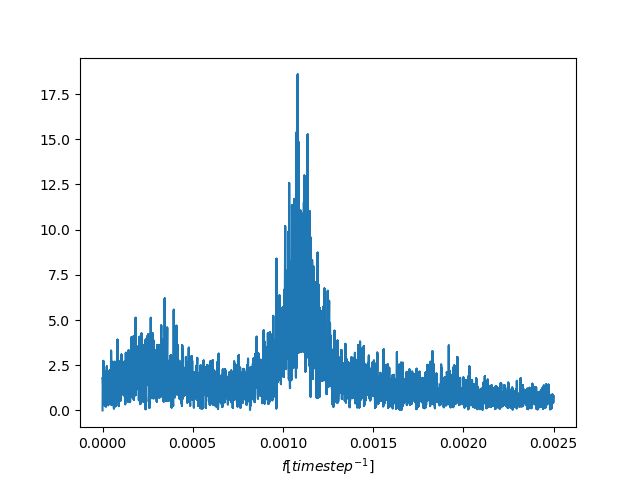

tau_osc =  924.0037071362373
osc_rms =  0.0353531289893114


In [44]:
n = 2
minstep = 3000
key = 'Temp'
data = block_average(lmp_data,n)

ss = np.array([s for i,s in enumerate(data['Step']) if s > minstep])
ks = np.array([k for i,k in enumerate(data[key]) if data['Step'][i] > minstep])
ks -= np.mean(ks)



spectrum = np.fft.fft(ks)
freqs = np.fft.fftfreq(ks.shape[-1])/(ss[1] - ss[0])

plt.figure()
#plt.xlim(0,0.006)
plt.plot(np.abs(freqs),np.abs(spectrum))
plt.xlabel('$f [timestep^{-1}]$')

# plt.savefig('report/img/T_spectrum.pgf')

tau = 1./np.abs(freqs[np.argmax(np.abs(spectrum))])
print('tau_osc = ',tau)
print('osc_rms = ',np.std(ks))

<IPython.core.display.Javascript object>


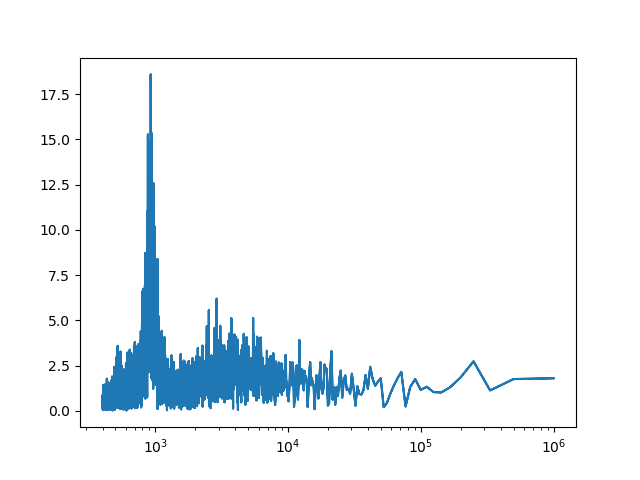

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [46]:
plt.figure()
plt.plot(1./np.abs(freqs),np.abs(spectrum))

<IPython.core.display.Javascript object>


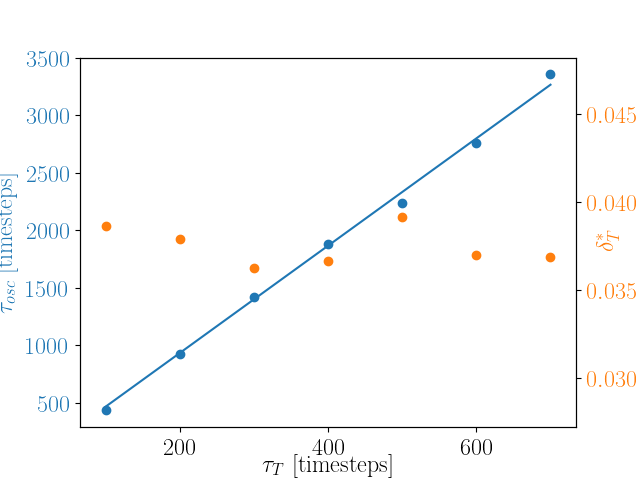

[4.66742857]


In [19]:
tau_Ts = np.array([100, 200, 300, 400, 500, 600, 700]) #in timesteps
tau_oscs = np.array([435, 922, 1424, 1880, 2238, 2764, 3357])
osc_rms = np.array([0.03867, 0.03794, 0.03628, 0.03664, 0.03916, 0.03699, 0.03688])

@np.vectorize
def lf(x,m):
    return m*x
popt,pcov = op.curve_fit(lf,tau_Ts,tau_oscs,p0=[1])

fig,ax = plt.subplots()
ax.xaxis.set_label_coords(0.5,-0.08)

color = 'tab:blue'
ax.set_xlabel(r'$\tau_T$ [timesteps]')
ax.set_ylabel(r'$\tau_{osc}$ [timesteps]',color=color)
ax.scatter(tau_Ts,tau_oscs,color=color)
ax.plot(tau_Ts,lf(tau_Ts,*popt))
ax.tick_params(axis='y', labelcolor=color)

color = 'tab:orange'
ax2 = ax.twinx()
ax2.yaxis.set_label_coords(1.05,0.5)
ax2.set_ylabel(r'$\delta_T^*$',color=color)
ax2.scatter(tau_Ts,osc_rms,color=color)
ax2.tick_params(axis='y', labelcolor=color)

# plt.savefig('report/img/tau_T.pgf')
print(popt)


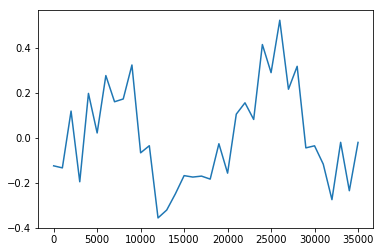

In [33]:
v = []
window = 15
key = 'Temp'

for i in range(len(lmp_data['Step']) - window):
    c = correlation(lmp_data,i,i+window,key)
    s = lmp_data['Step'][i]
    v.append([s,c])
v = np.array(v)
#print(v)
plt.figure()
plt.plot(v[:,0],v[:,1])

## Try simulate

In [6]:
folder = 'lattice_11_11_11__2_2_2/T_0.5__P_0.5'
avgs,stds = simulate(folder,input_data_file='lattice_11_11_11__2_2_2/lattice_11_11_11__2_2_2.data',
                    T0=0.5,T=0.5,P=0.5,verbose=True)

written file lattice_11_11_11__2_2_2/T_0.5__P_0.5/in.inp


data production starts from step 11000


In [7]:
avgs, stds

(array([5.03410043e-01, 5.53135877e-01, 1.46466915e+03]),
 array([0.01164142, 0.13490002, 5.69174364]))

In [19]:
names = ['Temp','Press','Volume']
vdw = pd.DataFrame(data=[avgs],columns=names)
vdw.loc[len(vdw)] = stds
vdw

,Temp,Press,Volume
0,0.503410,0.553136,1464.669150
1,0.011641,0.134900,5.691744


In [16]:
len(vdw)

1

In [25]:
xy = np.array([[0,1],[1,0],[2,2]])
for x,y in xy:
    print(x,y)

0 1
1 0
2 2


In [47]:
a = np.arange(4)
b = np.arange(5,10)
np.concatenate(np.array(np.meshgrid(a,b)).T,axis=0)
for x,y in np.concatenate(np.array(np.meshgrid(a,b)).T,axis=0):
    print(x,y)

0 5
0 6
0 7
0 8
0 9
1 5
1 6
1 7
1 8
1 9
2 5
2 6
2 7
2 8
2 9
3 5
3 6
3 7
3 8
3 9


In [37]:
help(np.stack)

Help on function stack in module numpy:

stack(arrays, axis=0, out=None)
    Join a sequence of arrays along a new axis.
    
    The `axis` parameter specifies the index of the new axis in the dimensions
    of the result. For example, if ``axis=0`` it will be the first dimension
    and if ``axis=-1`` it will be the last dimension.
    
    .. versionadded:: 1.10.0
    
    Parameters
    ----------
    arrays : sequence of array_like
        Each array must have the same shape.
    axis : int, optional
        The axis in the result array along which the input arrays are stacked.
    out : ndarray, optional
        If provided, the destination to place the result. The shape must be
        correct, matching that of what stack would have returned if no
        out argument were specified.
    
    Returns
    -------
    stacked : ndarray
        The stacked array has one more dimension than the input arrays.
    
    See Also
    --------
    concatenate : Join a sequence of arrays 